# <span style="color:blue">Cleaning & preprocessing (2019_Jul)</span>

In [1]:
yyyy_MMM = '2019_Jul'

### Load packages

In [2]:
import contractions, csv, emoji, os, re, string, time, unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from langdetect import detect
from wordcloud import WordCloud
from wordsegment import load, segment
load()
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

print('package --> pandas --> version --> ' + pd.__version__)
print('package --> re     --> version --> ' + re.__version__)
print('package --> ntlk   --> version --> ' + nltk.__version__)

package --> pandas --> version --> 1.1.3
package --> re     --> version --> 2.2.1
package --> ntlk   --> version --> 3.5


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\minio\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\minio\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\minio\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\minio\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Constants

In [3]:
# for reproducible results
random_state = 33
# if debug is True, messages during the process are generated
debug = True
# if the test is True, the process runs on a smaller subset of raw data (json files)
test = False
# id of the step during cleaning/preprocessing
step_num = 0
# path with the documents to preprocess
if test:
    path_doc = r'D:\master\data science\semestre 4\M2.979 - tfm\data\bins_test\doc'
else:
    path_doc = r'D:\master\data science\semestre 4\M2.979 - tfm\data\bins\doc'

# path + file for list stopwords extend
file_list_stopwords_extend = r'D:\master\data science\semestre 4\M2.979 - tfm\data\list_stopwords_extend.csv'
# path + file for list stopwords extend (for instagram)
file_list_stopwords_extend_instagram = r'D:\master\data science\semestre 4\M2.979 - tfm\data\list_stopwords_extend_instagram.csv'
    
file_doc = os.path.join(path_doc, yyyy_MMM, yyyy_MMM)
print('file to clean & preprocess - ', file_doc  + '.csv')

file to clean & preprocess -  D:\master\data science\semestre 4\M2.979 - tfm\data\bins\doc\2019_Jul\2019_Jul.csv


# Load data

In [4]:
step_name = 'load_data'

In [5]:
time_start = time.time()

# read/load data
df = pd.read_csv(file_doc + '.csv', names=['id_doc', 'content'])
# we duplicate the 'content' field. Data cleaning/preprocessing will be done over the new duplicated field, 'content_preprocessed'
df['content_preprocessed'] = df['content']

time_end = time.time()
hour, rem = divmod(time_end - time_start, 3600)
minute, second = divmod(rem, 60)
print('time elapsed {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))

print(df['content'].head(5))

time elapsed 00:00:01.08
0    { Comme un lundi au bureau ~ #TeamVacances ou ...
1    Kalau ini video berlanjut terus.. bakal jadi “...
2    you guys: do wearable easy going out glam look...
3    Eigenlijk wilde ik mijn verjaardag vandaag sti...
4    🧜🏼‍♀️ My new pinupstars campaign 📷⁣ Starring m...
Name: content, dtype: object


# Data cleaning

### Remove rows with blank/null content field

In [6]:
df['content_preprocessed'].replace('', np.nan, inplace=True)
print('Null values before - ', df['content_preprocessed'].isnull().sum())
df = df[df['content_preprocessed'].notnull()]
print('Null values after - ', df['content_preprocessed'].isnull().sum())

Null values before -  2610
Null values after -  0


### Remove values 'content' duplicated

In [7]:
print('Num rows before - ', str(len(df)))
df.drop_duplicates(subset ='content', keep=False, inplace=True) 
print('Num rows after - ', str(len(df)))

Num rows before -  148666
Num rows after -  143059


### Lowercase

In [8]:
step_name = 'to_lowercase'
step_num += 1
step_num

1

In [9]:
time_start = time.time()

df['content_preprocessed'] = df['content_preprocessed'].map(lambda x: str(x).lower())
if debug:
    df['content_to_lowercase'] = df['content_preprocessed']
df.to_csv(file_doc + '_' + str(step_num).zfill(2) + '_' + step_name + '.csv', index=False, header=True)

time_end = time.time()
hour, rem = divmod(time_end - time_start, 3600)
minute, second = divmod(rem, 60)
print('time elapsed - {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))

print(df['content'].head(5))
print(df['content_preprocessed'].head(5))

time elapsed - 00:00:04.31
0    { Comme un lundi au bureau ~ #TeamVacances ou ...
1    Kalau ini video berlanjut terus.. bakal jadi “...
2    you guys: do wearable easy going out glam look...
3    Eigenlijk wilde ik mijn verjaardag vandaag sti...
4    🧜🏼‍♀️ My new pinupstars campaign 📷⁣ Starring m...
Name: content, dtype: object
0    { comme un lundi au bureau ~ #teamvacances ou ...
1    kalau ini video berlanjut terus.. bakal jadi “...
2    you guys: do wearable easy going out glam look...
3    eigenlijk wilde ik mijn verjaardag vandaag sti...
4    🧜🏼‍♀️ my new pinupstars campaign 📷⁣ starring m...
Name: content_preprocessed, dtype: object


### Remove extra whitespaces

In [10]:
step_name = 'remove_extra_whitespaces_1'
step_num += 1
step_num

2

In [11]:
time_start = time.time()

# generate regular expression pattern
re_pattern = r' +'
df['content_preprocessed'] = df['content_preprocessed'].apply(lambda x: re.sub(re_pattern, ' ', x))
if debug:
    df['content_remove_extra_whitespaces_1'] = df['content_preprocessed']
df.to_csv(file_doc + '_' + str(step_num).zfill(2) + '_' + step_name + '.csv', index=False, header=True)

time_end = time.time()
hour, rem = divmod(time_end - time_start, 3600)
minute, second = divmod(rem, 60)
print('time elapsed - {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))

print(df['content'].head(5))
print(df['content_preprocessed'].head(5))

time elapsed - 00:00:07.61
0    { Comme un lundi au bureau ~ #TeamVacances ou ...
1    Kalau ini video berlanjut terus.. bakal jadi “...
2    you guys: do wearable easy going out glam look...
3    Eigenlijk wilde ik mijn verjaardag vandaag sti...
4    🧜🏼‍♀️ My new pinupstars campaign 📷⁣ Starring m...
Name: content, dtype: object
0    { comme un lundi au bureau ~ #teamvacances ou ...
1    kalau ini video berlanjut terus.. bakal jadi “...
2    you guys: do wearable easy going out glam look...
3    eigenlijk wilde ik mijn verjaardag vandaag sti...
4    🧜🏼‍♀️ my new pinupstars campaign 📷⁣ starring m...
Name: content_preprocessed, dtype: object


### Replace websites by whitespaces  
https://emailregex.com/

In [12]:
step_name = 'remove_websites'
step_num += 1
step_num

3

In [13]:
time_start = time.time()

# generate regular expression pattern
re_pattern = r'((http[s]?://)|(www))(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
df['content_preprocessed'] = df['content_preprocessed'].apply(lambda x: re.sub(re_pattern, ' ', str(x)))
if debug:
    df['content_remove_websites'] = df['content_preprocessed']
df.to_csv(file_doc + '_' + str(step_num).zfill(2) + '_' + step_name + '.csv', index=False, header=True)

time_end = time.time()
hour, rem = divmod(time_end - time_start, 3600)
minute, second = divmod(rem, 60)
print('time elapsed - {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))

print(df['content'].head(5))
print(df['content_preprocessed'].head(5))

time elapsed - 00:00:07.54
0    { Comme un lundi au bureau ~ #TeamVacances ou ...
1    Kalau ini video berlanjut terus.. bakal jadi “...
2    you guys: do wearable easy going out glam look...
3    Eigenlijk wilde ik mijn verjaardag vandaag sti...
4    🧜🏼‍♀️ My new pinupstars campaign 📷⁣ Starring m...
Name: content, dtype: object
0    { comme un lundi au bureau ~ #teamvacances ou ...
1    kalau ini video berlanjut terus.. bakal jadi “...
2    you guys: do wearable easy going out glam look...
3    eigenlijk wilde ik mijn verjaardag vandaag sti...
4    🧜🏼‍♀️ my new pinupstars campaign 📷⁣ starring m...
Name: content_preprocessed, dtype: object


### Replace emails by whitespaces

In [14]:
step_name = 'remove_emails'
step_num += 1
step_num

4

In [15]:
time_start = time.time()

# generate regular expression pattern
re_pattern = r'([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)'
df['content_preprocessed'] = df['content_preprocessed'].apply(lambda x: re.sub(re_pattern, ' ', x))
if debug:
    df['content_remove_emails'] = df['content_preprocessed']
df.to_csv(file_doc + '_' + str(step_num).zfill(2) + '_' + step_name + '.csv', index=False, header=True)

time_end = time.time()
hour, rem = divmod(time_end - time_start, 3600)
minute, second = divmod(rem, 60)
print('time elapsed - {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))

print(df['content'].head(5))
print(df['content_preprocessed'].head(5))

time elapsed - 00:00:14.15
0    { Comme un lundi au bureau ~ #TeamVacances ou ...
1    Kalau ini video berlanjut terus.. bakal jadi “...
2    you guys: do wearable easy going out glam look...
3    Eigenlijk wilde ik mijn verjaardag vandaag sti...
4    🧜🏼‍♀️ My new pinupstars campaign 📷⁣ Starring m...
Name: content, dtype: object
0    { comme un lundi au bureau ~ #teamvacances ou ...
1    kalau ini video berlanjut terus.. bakal jadi “...
2    you guys: do wearable easy going out glam look...
3    eigenlijk wilde ik mijn verjaardag vandaag sti...
4    🧜🏼‍♀️ my new pinupstars campaign 📷⁣ starring m...
Name: content_preprocessed, dtype: object


### Replace most common  meaningless hashtags by whitespaces  
https://towardsdatascience.com/basic-tweet-preprocessing-in-python-efd8360d529e

In [16]:
step_name = 'remove_meaningless_hashtags'
step_num += 1
step_num

5

In [17]:
time_start = time.time()

# read meaningless hastags
hashtags = csv.reader(open(r'D:\master\data science\semestre 4\M2.979 - tfm\data\list_meaningless_hashtags.csv'))
# generate regular expression pattern with all the meaningless hashtags to be removed
i = 0
regex = "r'"
for hashtag in hashtags:
    if i>0:
        regex = regex + '|(' + hashtag[0] + ')'
    else:
        regex = regex + '(' + hashtag[0] + ')'
    i += 1
regex = regex + "'"

re_pattern = regex
df['content_preprocessed'] = df['content_preprocessed'].apply(lambda x: re.sub(re_pattern, ' ', x))
if debug:
    df['content_remove_meaningless_hashtags'] = df['content_preprocessed']
df.to_csv(file_doc + '_' + str(step_num).zfill(2) + '_' + step_name + '.csv', index=False, header=True)

time_end = time.time()
hour, rem = divmod(time_end - time_start, 3600)
minute, second = divmod(rem, 60)
print('time elapsed - {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))

print(df['content'].head(5))
print(df['content_preprocessed'].head(5))

time elapsed - 00:02:09.07
0    { Comme un lundi au bureau ~ #TeamVacances ou ...
1    Kalau ini video berlanjut terus.. bakal jadi “...
2    you guys: do wearable easy going out glam look...
3    Eigenlijk wilde ik mijn verjaardag vandaag sti...
4    🧜🏼‍♀️ My new pinupstars campaign 📷⁣ Starring m...
Name: content, dtype: object
0    { comme un lundi au bureau ~ #teamvacances ou ...
1    kalau ini video berlanjut terus.. bakal jadi “...
2    you guys: do wearable easy going out glam look...
3    eigenlijk wilde ik mijn verjaardag vandaag sti...
4    🧜🏼‍♀️ my new pinupstars campaign 📷⁣ starring m...
Name: content_preprocessed, dtype: object


### Replace hashtag symbol (#) by whitespaces  
https://towardsdatascience.com/basic-tweet-preprocessing-in-python-efd8360d529e

In [18]:
step_name = 'remove_hashtag_symbol'
step_num += 1
step_num

6

In [19]:
time_start = time.time()

# generate regular expression pattern
re_pattern = r'(#)'
df['content_preprocessed'] = df['content_preprocessed'].apply(lambda x: re.sub(re_pattern, ' ', x))
if debug:
    df['content_remove_hashtag_symbol'] = df['content_preprocessed']
df.to_csv(file_doc + '_' + str(step_num).zfill(2) + '_' + step_name + '.csv', index=False, header=True)

time_end = time.time()
hour, rem = divmod(time_end - time_start, 3600)
minute, second = divmod(rem, 60)
print('time elapsed - {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))

print(df['content'].head(5))
print(df['content_preprocessed'].head(5))

time elapsed - 00:00:08.67
0    { Comme un lundi au bureau ~ #TeamVacances ou ...
1    Kalau ini video berlanjut terus.. bakal jadi “...
2    you guys: do wearable easy going out glam look...
3    Eigenlijk wilde ik mijn verjaardag vandaag sti...
4    🧜🏼‍♀️ My new pinupstars campaign 📷⁣ Starring m...
Name: content, dtype: object
0    { comme un lundi au bureau ~  teamvacances ou ...
1    kalau ini video berlanjut terus.. bakal jadi “...
2    you guys: do wearable easy going out glam look...
3    eigenlijk wilde ik mijn verjaardag vandaag sti...
4    🧜🏼‍♀️ my new pinupstars campaign 📷⁣ starring m...
Name: content_preprocessed, dtype: object


### Replace mentions (@) by whitespaces

In [20]:
step_name = 'remove_mentions'
step_num += 1
step_num

7

In [21]:
time_start = time.time()

# generate regular expression pattern
re_pattern = r'(@\w+)'
df['content_preprocessed'] = df['content_preprocessed'].apply(lambda x: re.sub(re_pattern, ' ', x))
if debug:
    df['content_remove_mentions'] = df['content_preprocessed']
df.to_csv(file_doc + '_' + str(step_num).zfill(2) + '_' + step_name + '.csv', index=False, header=True)

time_end = time.time()
hour, rem = divmod(time_end - time_start, 3600)
minute, second = divmod(rem, 60)
print('time elapsed - {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))

print(df['content'].head(5))
print(df['content_preprocessed'].head(5))

time elapsed - 00:00:09.11
0    { Comme un lundi au bureau ~ #TeamVacances ou ...
1    Kalau ini video berlanjut terus.. bakal jadi “...
2    you guys: do wearable easy going out glam look...
3    Eigenlijk wilde ik mijn verjaardag vandaag sti...
4    🧜🏼‍♀️ My new pinupstars campaign 📷⁣ Starring m...
Name: content, dtype: object
0    { comme un lundi au bureau ~  teamvacances ou ...
1    kalau ini video berlanjut terus.. bakal jadi “...
2    you guys: do wearable easy going out glam look...
3    eigenlijk wilde ik mijn verjaardag vandaag sti...
4    🧜🏼‍♀️ my new pinupstars campaign 📷⁣ starring m...
Name: content_preprocessed, dtype: object


### Replace emojis by whitespaces

In [22]:
step_name = 'remove_colons'
step_num += 1
step_num

8

In [23]:
time_start = time.time()

# generate regular expression pattern for removing colon punctuation (:)
re_pattern = r'(:)'
df['content_preprocessed'] = df['content_preprocessed'].apply(lambda x: re.sub(re_pattern, ' ', str(x)))
if debug:
    df['content_remove_colons'] = df['content_preprocessed']
df.to_csv(file_doc + '_' + str(step_num).zfill(2) + '_' + step_name + '.csv', index=False, header=True)

time_end = time.time()
hour, rem = divmod(time_end - time_start, 3600)
minute, second = divmod(rem, 60)
print('time elapsed - {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))

print(df['content'].head(5))
print(df['content_preprocessed'].head(5))

time elapsed - 00:00:10.42
0    { Comme un lundi au bureau ~ #TeamVacances ou ...
1    Kalau ini video berlanjut terus.. bakal jadi “...
2    you guys: do wearable easy going out glam look...
3    Eigenlijk wilde ik mijn verjaardag vandaag sti...
4    🧜🏼‍♀️ My new pinupstars campaign 📷⁣ Starring m...
Name: content, dtype: object
0    { comme un lundi au bureau ~  teamvacances ou ...
1    kalau ini video berlanjut terus.. bakal jadi “...
2    you guys  do wearable easy going out glam look...
3    eigenlijk wilde ik mijn verjaardag vandaag sti...
4    🧜🏼‍♀️ my new pinupstars campaign 📷⁣ starring m...
Name: content_preprocessed, dtype: object


In [24]:
step_name = 'replace_emojis'
step_num += 1
step_num

9

In [25]:
time_start = time.time()

# replace emoji by its short name between ':' --> e.g. --> :face_blowing_a_kiss:
df['content_preprocessed'] = df['content_preprocessed'].map(lambda x: emoji.demojize(x))
if debug:
    df['content_replace_emojis'] = df['content_preprocessed']
df.to_csv(file_doc + '_' + str(step_num).zfill(2) + '_' + step_name + '.csv', index=False, header=True)

time_end = time.time()
hour, rem = divmod(time_end - time_start, 3600)
minute, second = divmod(rem, 60)
print('time elapsed - {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))

print(df['content'].head(5))
print(df['content_preprocessed'].head(5))

time elapsed - 00:04:10.30
0    { Comme un lundi au bureau ~ #TeamVacances ou ...
1    Kalau ini video berlanjut terus.. bakal jadi “...
2    you guys: do wearable easy going out glam look...
3    Eigenlijk wilde ik mijn verjaardag vandaag sti...
4    🧜🏼‍♀️ My new pinupstars campaign 📷⁣ Starring m...
Name: content, dtype: object
0    { comme un lundi au bureau ~  teamvacances ou ...
1    kalau ini video berlanjut terus.. bakal jadi “...
2    you guys  do wearable easy going out glam look...
3    eigenlijk wilde ik mijn verjaardag vandaag sti...
4    :mermaid_medium-light_skin_tone: my new pinups...
Name: content_preprocessed, dtype: object


In [26]:
step_name = 'remove_emojis'
step_num += 1
step_num

10

In [27]:
time_start = time.time()

# generate regular expression pattern for removing emoji's short name between ':'
re_pattern = r'\:(.*?)\:'
df['content_preprocessed'] = df['content_preprocessed'].apply(lambda x: re.sub(re_pattern, ' ', x))
if debug:
    df['content_remove_emojis'] = df['content_preprocessed']
df.to_csv(file_doc + '_' + str(step_num).zfill(2) + '_' + step_name + '.csv', index=False, header=True)

time_end = time.time()
hour, rem = divmod(time_end - time_start, 3600)
minute, second = divmod(rem, 60)
print('time elapsed - {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))

print(df['content'].head(5))
print(df['content_preprocessed'].head(5))

time elapsed - 00:00:12.26
0    { Comme un lundi au bureau ~ #TeamVacances ou ...
1    Kalau ini video berlanjut terus.. bakal jadi “...
2    you guys: do wearable easy going out glam look...
3    Eigenlijk wilde ik mijn verjaardag vandaag sti...
4    🧜🏼‍♀️ My new pinupstars campaign 📷⁣ Starring m...
Name: content, dtype: object
0    { comme un lundi au bureau ~  teamvacances ou ...
1    kalau ini video berlanjut terus.. bakal jadi “...
2    you guys  do wearable easy going out glam look...
3    eigenlijk wilde ik mijn verjaardag vandaag sti...
4      my new pinupstars campaign  ⁣ starring myrie...
Name: content_preprocessed, dtype: object


### Replace numbers by whitespaces

In [28]:
step_name = 'remove_numbers'
step_num += 1
step_num

11

In [29]:
time_start = time.time()

# generate regular expression pattern
re_pattern = r'[^a-zA-z.,!?/:;\"\'\s]'
df['content_preprocessed'] = df['content_preprocessed'].apply(lambda x: re.sub(re_pattern, ' ', x))
if debug:
    df['content_remove_numbers'] = df['content_preprocessed']
df.to_csv(file_doc + '_' + str(step_num).zfill(2) + '_' + step_name + '.csv', index=False, header=True)

time_end = time.time()
hour, rem = divmod(time_end - time_start, 3600)
minute, second = divmod(rem, 60)
print('time elapsed - {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))

print(df['content'].head(5))
print(df['content_preprocessed'].head(5))

time elapsed - 00:00:14.07
0    { Comme un lundi au bureau ~ #TeamVacances ou ...
1    Kalau ini video berlanjut terus.. bakal jadi “...
2    you guys: do wearable easy going out glam look...
3    Eigenlijk wilde ik mijn verjaardag vandaag sti...
4    🧜🏼‍♀️ My new pinupstars campaign 📷⁣ Starring m...
Name: content, dtype: object
0      comme un lundi au bureau    teamvacances ou ...
1    kalau ini video berlanjut terus.. bakal jadi  ...
2    you guys  do wearable easy going out glam look...
3    eigenlijk wilde ik mijn verjaardag vandaag sti...
4      my new pinupstars campaign    starring myrie...
Name: content_preprocessed, dtype: object


### Remove accented characters  
https://towardsdatascience.com/nlp-building-text-cleanup-and-preprocessing-pipeline-eba4095245a0

In [30]:
step_name = 'remove_accents'
step_num += 1
step_num

12

In [31]:
# function to remove accented characters
def remove_accented_chars(text):
   new_text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
   return new_text

time_start = time.time()

# call function to remove accented characters (remove_accented_chars)
df['content_preprocessed'] = df['content_preprocessed'].map(lambda x: remove_accented_chars(x))
if debug:
    df['content_remove_accents'] = df['content_preprocessed']
df.to_csv(file_doc + '_' + str(step_num).zfill(2) + '_' + step_name + '.csv', index=False, header=True)

time_end = time.time()
hour, rem = divmod(time_end - time_start, 3600)
minute, second = divmod(rem, 60)
print('time elapsed - {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))

print(df['content'].head(5))
print(df['content_preprocessed'].head(5))

time elapsed - 00:00:14.12
0    { Comme un lundi au bureau ~ #TeamVacances ou ...
1    Kalau ini video berlanjut terus.. bakal jadi “...
2    you guys: do wearable easy going out glam look...
3    Eigenlijk wilde ik mijn verjaardag vandaag sti...
4    🧜🏼‍♀️ My new pinupstars campaign 📷⁣ Starring m...
Name: content, dtype: object
0      comme un lundi au bureau    teamvacances ou ...
1    kalau ini video berlanjut terus.. bakal jadi  ...
2    you guys  do wearable easy going out glam look...
3    eigenlijk wilde ik mijn verjaardag vandaag sti...
4      my new pinupstars campaign    starring myrie...
Name: content_preprocessed, dtype: object


### Replace special characters by whitespaces

In [32]:
step_name = 'remove_special_characters'
step_num += 1
step_num

13

In [33]:
time_start = time.time()

# pattern to keep
re_pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]'
df['content_preprocessed'] = df['content_preprocessed'].apply(lambda x: re.sub(re_pattern, ' ', x))
if debug:
    df['content_remove_special_characters'] = df['content_preprocessed']
df.to_csv(file_doc + '_' + str(step_num).zfill(2) + '_' + step_name + '.csv', index=False, header=True)

time_end = time.time()
hour, rem = divmod(time_end - time_start, 3600)
minute, second = divmod(rem, 60)
print('time elapsed - {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))

print(df['content'].head(5))
print(df['content_preprocessed'].head(5))

time elapsed - 00:00:15.16
0    { Comme un lundi au bureau ~ #TeamVacances ou ...
1    Kalau ini video berlanjut terus.. bakal jadi “...
2    you guys: do wearable easy going out glam look...
3    Eigenlijk wilde ik mijn verjaardag vandaag sti...
4    🧜🏼‍♀️ My new pinupstars campaign 📷⁣ Starring m...
Name: content, dtype: object
0      comme un lundi au bureau    teamvacances ou ...
1    kalau ini video berlanjut terus.. bakal jadi  ...
2    you guys  do wearable easy going out glam look...
3    eigenlijk wilde ik mijn verjaardag vandaag sti...
4      my new pinupstars campaign    starring myrie...
Name: content_preprocessed, dtype: object


### Expand contractions

In [34]:
step_name = 'expand_contractions'
step_num += 1
step_num

14

In [35]:
time_start = time.time()

df['content_preprocessed'] = df['content_preprocessed'].apply(lambda x: contractions.fix(x))
if debug:
    df['content_expand_contractions'] = df['content_preprocessed']
df.to_csv(file_doc + '_' + str(step_num).zfill(2) + '_' + step_name + '.csv', index=False, header=True)

time_end = time.time()
hour, rem = divmod(time_end - time_start, 3600)
minute, second = divmod(rem, 60)
print('time elapsed - {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))

print(df['content'].head(5))
print(df['content_preprocessed'].head(5))

time elapsed - 00:00:17.79
0    { Comme un lundi au bureau ~ #TeamVacances ou ...
1    Kalau ini video berlanjut terus.. bakal jadi “...
2    you guys: do wearable easy going out glam look...
3    Eigenlijk wilde ik mijn verjaardag vandaag sti...
4    🧜🏼‍♀️ My new pinupstars campaign 📷⁣ Starring m...
Name: content, dtype: object
0      comme un lundi au bureau    teamvacances ou ...
1    kalau ini video berlanjut terus.. bakal jadi  ...
2    you guys  do wearable easy going out glam look...
3    eigenlijk wilde ik mijn verjaardag vandaag sti...
4      my new pinupstars campaign    starring myrie...
Name: content_preprocessed, dtype: object


### Remove extra whitespaces

In [36]:
step_name = 'remove_extra_whitespaces_2'
step_num += 1
step_num

15

In [37]:
time_start = time.time()

# generate regular expression pattern
re_pattern = r' +'
df['content_preprocessed'] = df['content_preprocessed'].apply(lambda x: re.sub(re_pattern, ' ', x))
if debug:
    df['content_remove_extra_whitespaces_2'] = df['content_preprocessed']
df.to_csv(file_doc + '_' + str(step_num).zfill(2) + '_' + step_name + '.csv', index=False, header=True)

time_end = time.time()
hour, rem = divmod(time_end - time_start, 3600)
minute, second = divmod(rem, 60)
print('time elapsed - {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))

print(df['content'].head(5))
print(df['content_preprocessed'].head(5))

time elapsed - 00:00:18.86
0    { Comme un lundi au bureau ~ #TeamVacances ou ...
1    Kalau ini video berlanjut terus.. bakal jadi “...
2    you guys: do wearable easy going out glam look...
3    Eigenlijk wilde ik mijn verjaardag vandaag sti...
4    🧜🏼‍♀️ My new pinupstars campaign 📷⁣ Starring m...
Name: content, dtype: object
0     comme un lundi au bureau teamvacances ou team...
1    kalau ini video berlanjut terus.. bakal jadi j...
2    you guys do wearable easy going out glam looks...
3    eigenlijk wilde ik mijn verjaardag vandaag sti...
4     my new pinupstars campaign starring myriembou...
Name: content_preprocessed, dtype: object


### Replace punctuation by whitespaces

In [38]:
step_name = 'remove_punctuation'
step_num += 1
step_num

16

In [39]:
time_start = time.time()

# generate regular expression pattern
re_pattern = r'[^\w\s]'
df['content_preprocessed'] = df['content_preprocessed'].apply(lambda x: re.sub(re_pattern, ' ', x))
if debug:
    df['content_remove_punctuation'] = df['content_preprocessed']
df.to_csv(file_doc + '_' + str(step_num).zfill(2) + '_' + step_name + '.csv', index=False, header=True)

time_end = time.time()
hour, rem = divmod(time_end - time_start, 3600)
minute, second = divmod(rem, 60)
print('time elapsed - {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))

print(df['content'].head(5))
print(df['content_preprocessed'].head(5))

time elapsed - 00:00:20.33
0    { Comme un lundi au bureau ~ #TeamVacances ou ...
1    Kalau ini video berlanjut terus.. bakal jadi “...
2    you guys: do wearable easy going out glam look...
3    Eigenlijk wilde ik mijn verjaardag vandaag sti...
4    🧜🏼‍♀️ My new pinupstars campaign 📷⁣ Starring m...
Name: content, dtype: object
0     comme un lundi au bureau teamvacances ou team...
1    kalau ini video berlanjut terus   bakal jadi j...
2    you guys do wearable easy going out glam looks...
3    eigenlijk wilde ik mijn verjaardag vandaag sti...
4     my new pinupstars campaign starring myriembou...
Name: content_preprocessed, dtype: object


### Remove words of up to 3 characters

In [40]:
step_name = 'remove_3_characters'
step_num += 1
step_num

17

In [41]:
time_start = time.time()

# pattern to keep
re_pattern = r'\b\w{1,3}\b'
df['content_preprocessed'] = df['content_preprocessed'].apply(lambda x: re.sub(re_pattern, '', x))
if debug:
    df['content_remove_3_characters_1'] = df['content_preprocessed']
df.to_csv(file_doc + '_' + str(step_num).zfill(2) + '_' + step_name + '.csv', index=False, header=True)

time_end = time.time()
hour, rem = divmod(time_end - time_start, 3600)
minute, second = divmod(rem, 60)
print('time elapsed - {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))

print(df['content'].head(5))
print(df['content_preprocessed'].head(5))

time elapsed - 00:00:26.12
0    { Comme un lundi au bureau ~ #TeamVacances ou ...
1    Kalau ini video berlanjut terus.. bakal jadi “...
2    you guys: do wearable easy going out glam look...
3    Eigenlijk wilde ik mijn verjaardag vandaag sti...
4    🧜🏼‍♀️ My new pinupstars campaign 📷⁣ Starring m...
Name: content, dtype: object
0     comme  lundi  bureau teamvacances  teamboulot...
1    kalau  video berlanjut terus   bakal jadi  ful...
2     guys  wearable easy going  glam looks   like ...
3    eigenlijk wilde  mijn verjaardag vandaag still...
4       pinupstars campaign starring myriemboukadid...
Name: content_preprocessed, dtype: object


### Replace underscore ( _ ) by whitespaces  
https://towardsdatascience.com/basic-tweet-preprocessing-in-python-efd8360d529e

In [42]:
step_name = 'remove_underscore'
step_num += 1
step_num

18

In [43]:
time_start = time.time()

# generate regular expression pattern
re_pattern = r'(_)'
df['content_preprocessed'] = df['content_preprocessed'].apply(lambda x: re.sub(re_pattern, ' ', x))
if debug:
    df['content_remove_underscore'] = df['content_preprocessed']
df.to_csv(file_doc + '_' + str(step_num).zfill(2) + '_' + step_name + '.csv', index=False, header=True)

time_end = time.time()
hour, rem = divmod(time_end - time_start, 3600)
minute, second = divmod(rem, 60)
print('time elapsed - {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))

print(df['content'].head(5))
print(df['content_preprocessed'].head(5))

time elapsed - 00:00:41.00
0    { Comme un lundi au bureau ~ #TeamVacances ou ...
1    Kalau ini video berlanjut terus.. bakal jadi “...
2    you guys: do wearable easy going out glam look...
3    Eigenlijk wilde ik mijn verjaardag vandaag sti...
4    🧜🏼‍♀️ My new pinupstars campaign 📷⁣ Starring m...
Name: content, dtype: object
0     comme  lundi  bureau teamvacances  teamboulot...
1    kalau  video berlanjut terus   bakal jadi  ful...
2     guys  wearable easy going  glam looks   like ...
3    eigenlijk wilde  mijn verjaardag vandaag still...
4       pinupstars campaign starring myriemboukadid...
Name: content_preprocessed, dtype: object


### Remove extra whitespaces

In [44]:
step_name = 'remove_extra_whitespaces_3'
step_num += 1
step_num

19

In [45]:
time_start = time.time()

# generate regular expression pattern
re_pattern = r' +'
df['content_preprocessed'] = df['content_preprocessed'].apply(lambda x: re.sub(re_pattern, ' ', x))
if debug:
    df['content_remove_extra_whitespaces_3'] = df['content_preprocessed']
df.to_csv(file_doc + '_' + str(step_num).zfill(2) + '_' + step_name + '.csv', index=False, header=True)

time_end = time.time()
hour, rem = divmod(time_end - time_start, 3600)
minute, second = divmod(rem, 60)
print('time elapsed - {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))

print(df['content'].head(5))
print(df['content_preprocessed'].head(5))

time elapsed - 00:00:42.07
0    { Comme un lundi au bureau ~ #TeamVacances ou ...
1    Kalau ini video berlanjut terus.. bakal jadi “...
2    you guys: do wearable easy going out glam look...
3    Eigenlijk wilde ik mijn verjaardag vandaag sti...
4    🧜🏼‍♀️ My new pinupstars campaign 📷⁣ Starring m...
Name: content, dtype: object
0     comme lundi bureau teamvacances teamboulot po...
1    kalau video berlanjut terus bakal jadi full fr...
2       guys wearable easy going glam looks like this 
3    eigenlijk wilde mijn verjaardag vandaag stille...
4     pinupstars campaign starring myriemboukadida ...
Name: content_preprocessed, dtype: object


### Detect language  
https://medium.com/1001-nights-in-data-science/three-methods-of-detecting-language-of-textual-data-2c7cc41033b1

In [46]:
step_name = 'detect_language'
step_num += 1
step_num

20

In [47]:
# function to detect language
def detect_language(text):
    try:
        language_detected = detect(text)
    except:
        language_detected = ''
    return language_detected

time_start = time.time()

# call function to detect language (detect_language)
df['language'] = df['content_preprocessed'].map(lambda x: detect_language(x))
if debug:
    df['content_detect_language'] = df['language']
df.to_csv(file_doc + '_' + str(step_num).zfill(2) + '_' + step_name + '.csv', index=False, header=True)

time_end = time.time()
hour, rem = divmod(time_end - time_start, 3600)
minute, second = divmod(rem, 60)
print('time elapsed - {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))

print(df['content'].head(5))
print(df['content_preprocessed'].head(5))

time elapsed - 00:25:44.17
0    { Comme un lundi au bureau ~ #TeamVacances ou ...
1    Kalau ini video berlanjut terus.. bakal jadi “...
2    you guys: do wearable easy going out glam look...
3    Eigenlijk wilde ik mijn verjaardag vandaag sti...
4    🧜🏼‍♀️ My new pinupstars campaign 📷⁣ Starring m...
Name: content, dtype: object
0     comme lundi bureau teamvacances teamboulot po...
1    kalau video berlanjut terus bakal jadi full fr...
2       guys wearable easy going glam looks like this 
3    eigenlijk wilde mijn verjaardag vandaag stille...
4     pinupstars campaign starring myriemboukadida ...
Name: content_preprocessed, dtype: object


### Select language (english)

In [48]:
step_name = 'select_english'
step_num += 1
step_num

21

In [49]:
time_start = time.time()

df = df[df['language'] == 'en']
# remove 'language' column
df.drop(['language'], inplace=True, axis=1)
df.to_csv(file_doc + '_' + str(step_num).zfill(2) + '_' + step_name + '.csv', index=False, header=True)

time_end = time.time()
hour, rem = divmod(time_end - time_start, 3600)
minute, second = divmod(rem, 60)
print('time elapsed - {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))

print(df['content'].head(5))
print(df['content_preprocessed'].head(5))

time elapsed - 00:00:13.54
2    you guys: do wearable easy going out glam look...
4    🧜🏼‍♀️ My new pinupstars campaign 📷⁣ Starring m...
6    Black Tape Project at Art Hearts Fashion 🇺🇸👙👙M...
7    Relax time... 🛶💦👫 #12yearstogether #годовщинас...
8    A little peak into my world.  Don’t you find i...
Name: content, dtype: object
2       guys wearable easy going glam looks like this 
4     pinupstars campaign starring myriemboukadida ...
6    black tape project hearts fashion miami swim w...
7                            relax time yearstogether 
8     little peak into world find little strange ha...
Name: content_preprocessed, dtype: object


### Wordsegmentation  
https://medium.com/analytics-vidhya/working-with-twitter-data-b0aa5419532

In [50]:
step_name = 'wordsegmentation'
step_num += 1
step_num

22

In [51]:
# function to perform word segmentation
def get_word_segment(text):
    text = ' '.join(segment(text))
    return text

# function to adapt the results obtained after executing word segmentation
# word segmentation returns a list of lists
def adapt_list(list_of_lists):
    result = [item for elem in list_of_lists for item in elem]
    return result

time_start = time.time()

# call function
df['content_preprocessed'] = df['content_preprocessed'].map(lambda x: get_word_segment(x))
#df['content'] = df['content'].map(lambda x: adapt_list(x))
if debug:
    df['content_wordsegmentation'] = df['content_preprocessed']
df.to_csv(file_doc + '_' + str(step_num).zfill(2) + '_' + step_name + '.csv', index=False, header=True)

time_end = time.time()
hour, rem = divmod(time_end - time_start, 3600)
minute, second = divmod(rem, 60)
print('time elapsed - {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))

print(df['content'].head(5))
print(df['content_preprocessed'].head(5))

time elapsed - 09:11:30.05
2    you guys: do wearable easy going out glam look...
4    🧜🏼‍♀️ My new pinupstars campaign 📷⁣ Starring m...
6    Black Tape Project at Art Hearts Fashion 🇺🇸👙👙M...
7    Relax time... 🛶💦👫 #12yearstogether #годовщинас...
8    A little peak into my world.  Don’t you find i...
Name: content, dtype: object
2        guys wearable easy going glam looks like this
4    pinup stars campaign starring my ri embo uk a ...
6    black tape project hearts fashion miami swim w...
7                            relax time years together
8    little peak into world find little strange hav...
Name: content_preprocessed, dtype: object


### Remove words of up to 3 characters

In [52]:
step_name = 'remove_3_characters'
step_num += 1
step_num

23

In [53]:
time_start = time.time()

# pattern to keep
re_pattern = r'\b\w{1,3}\b'
df['content_preprocessed'] = df['content_preprocessed'].apply(lambda x: re.sub(re_pattern, '', x))
if debug:
    df['content_remove_3_characters_2'] = df['content_preprocessed']
df.to_csv(file_doc + '_' + str(step_num).zfill(2) + '_' + step_name + '.csv', index=False, header=True)

time_end = time.time()
hour, rem = divmod(time_end - time_start, 3600)
minute, second = divmod(rem, 60)
print('time elapsed - {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))

print(df['content'].head(5))
print(df['content_preprocessed'].head(5))

time elapsed - 00:00:19.05
2    you guys: do wearable easy going out glam look...
4    🧜🏼‍♀️ My new pinupstars campaign 📷⁣ Starring m...
6    Black Tape Project at Art Hearts Fashion 🇺🇸👙👙M...
7    Relax time... 🛶💦👫 #12yearstogether #годовщинас...
8    A little peak into my world.  Don’t you find i...
Name: content, dtype: object
2        guys wearable easy going glam looks like this
4    pinup stars campaign starring   embo     styli...
6    black tape project hearts fashion miami swim w...
7                            relax time years together
8    little peak into world find little strange hav...
Name: content_preprocessed, dtype: object


# Data preprocessing

### Tokenization

In [54]:
step_name = 'tokenization'
step_num += 1
step_num

24

In [55]:
time_start = time.time()

df['content_preprocessed'] = df['content_preprocessed'].map(lambda x: word_tokenize(x))
if debug:
    df['content_tokenization'] = df['content_preprocessed']
df.to_csv(file_doc + '_' + str(step_num).zfill(2) + '_' + step_name + '.csv', index=False, header=True)

time_end = time.time()
hour, rem = divmod(time_end - time_start, 3600)
minute, second = divmod(rem, 60)
print('time elapsed - {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))

print(df['content'].head(5))
print(df['content_preprocessed'].head(5))

time elapsed - 00:00:42.44
2    you guys: do wearable easy going out glam look...
4    🧜🏼‍♀️ My new pinupstars campaign 📷⁣ Starring m...
6    Black Tape Project at Art Hearts Fashion 🇺🇸👙👙M...
7    Relax time... 🛶💦👫 #12yearstogether #годовщинас...
8    A little peak into my world.  Don’t you find i...
Name: content, dtype: object
2    [guys, wearable, easy, going, glam, looks, lik...
4    [pinup, stars, campaign, starring, embo, styli...
6    [black, tape, project, hearts, fashion, miami,...
7                       [relax, time, years, together]
8    [little, peak, into, world, find, little, stra...
Name: content_preprocessed, dtype: object


### Lemmatization  
https://towardsdatascience.com/nlp-building-text-cleanup-and-preprocessing-pipeline-eba4095245a0

In [56]:
step_name = 'lemmatization'
step_num += 1
step_num

25

In [57]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

# function to perform lemmatization
def get_lem(text):
    result = [WordNetLemmatizer().lemmatize(word, get_wordnet_pos(word)) for word in text]
    return result

time_start = time.time()

# call function
df['content_preprocessed'] = df['content_preprocessed'].map(lambda x: get_lem(x))
if debug:
    df['content_lemmatization'] = df['content_preprocessed']
df.to_csv(file_doc + '_' + str(step_num).zfill(2) + '_' + step_name + '.csv', index=False, header=True)

time_end = time.time()
hour, rem = divmod(time_end - time_start, 3600)
minute, second = divmod(rem, 60)
print('time elapsed - {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))

print(df['content'].head(5))
print(df['content_preprocessed'].head(5))

time elapsed - 00:33:48.55
2    you guys: do wearable easy going out glam look...
4    🧜🏼‍♀️ My new pinupstars campaign 📷⁣ Starring m...
6    Black Tape Project at Art Hearts Fashion 🇺🇸👙👙M...
7    Relax time... 🛶💦👫 #12yearstogether #годовщинас...
8    A little peak into my world.  Don’t you find i...
Name: content, dtype: object
2    [guy, wearable, easy, go, glam, look, like, this]
4    [pinup, star, campaign, star, embo, style, hai...
6    [black, tape, project, heart, fashion, miami, ...
7                        [relax, time, year, together]
8    [little, peak, into, world, find, little, stra...
Name: content_preprocessed, dtype: object


### Wordcloud with top 50 words (before stopwords)

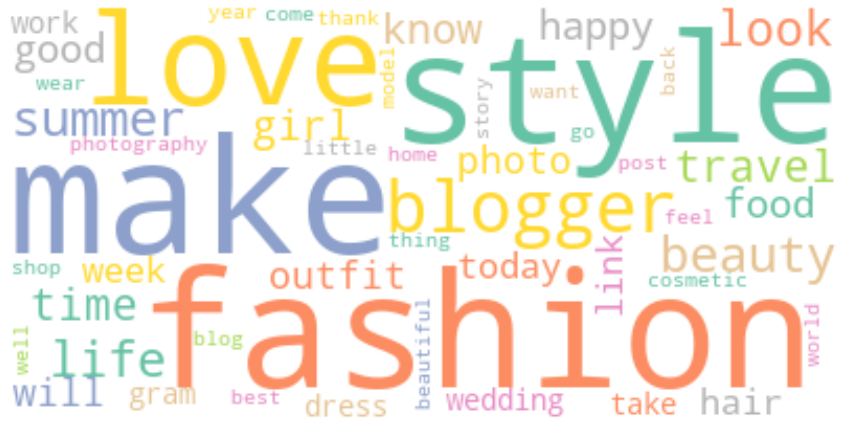

In [58]:
list_words = df.content_preprocessed.tolist()
list_words = adapt_list(list_words)
list_words = ' '.join([text for text in list_words])

# create a wordcloud object
wordcloud = WordCloud(background_color='white'
                      ,colormap='Set2'
                      ,collocations=False
                      ,max_words=50
                     )
# generate a wordcloud
wordcloud.generate(list_words)
# visualize the wordcloud
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

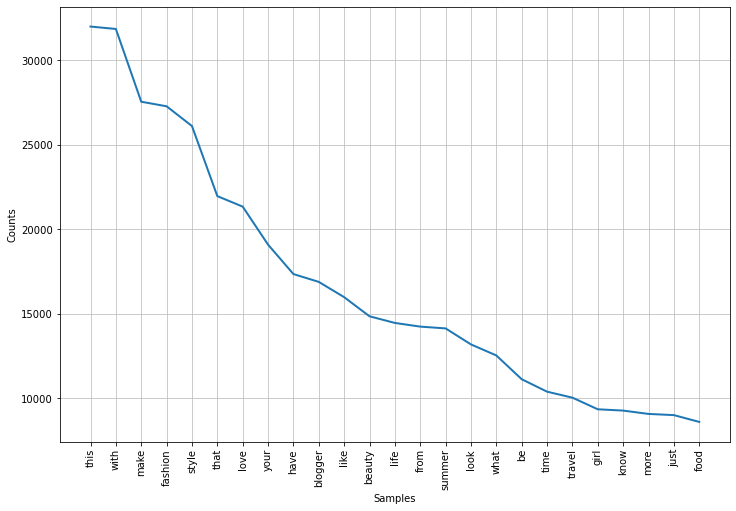

In [59]:
list_words = df.content_preprocessed.tolist()
list_words = adapt_list(list_words)
freq_dist = FreqDist(list_words)

fig, ax = plt.subplots(figsize=(12, 8))
freq_dist.plot(25, cumulative=False)
plt.show()

### Remove stopwords  
https://towardsdatascience.com/basic-tweet-preprocessing-in-python-efd8360d529e  
https://www.ranks.nl/stopwords

In [60]:
step_name = 'stopwords'
step_num += 1
step_num

26

In [61]:
time_start = time.time()

stop_words = stopwords.words('english')

# read stopwords to add to the default list
df_stopwords_extend = pd.read_csv(file_list_stopwords_extend, names=['word'])
# dataframe to list
stopwords_extend = df_stopwords_extend['word'].values.tolist()
# extend stopwords
stop_words.extend(stopwords_extend)
# remove duplicate elements in the list
stop_words = list(dict.fromkeys(stop_words))

df['content_preprocessed'] = df['content_preprocessed'].apply(lambda x: [item for item in x if item not in stop_words])
if debug:
    df['content_stopwords'] = df['content_preprocessed']
df.to_csv(file_doc + '_' + str(step_num).zfill(2) + '_' + step_name + '.csv', index=False, header=True)

time_end = time.time()
hour, rem = divmod(time_end - time_start, 3600)
minute, second = divmod(rem, 60)
print('time elapsed - {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))

print(df['content'].head(5))
print(df['content_preprocessed'].head(5))

time elapsed - 00:00:42.57
2    you guys: do wearable easy going out glam look...
4    🧜🏼‍♀️ My new pinupstars campaign 📷⁣ Starring m...
6    Black Tape Project at Art Hearts Fashion 🇺🇸👙👙M...
7    Relax time... 🛶💦👫 #12yearstogether #годовщинас...
8    A little peak into my world.  Don’t you find i...
Name: content, dtype: object
2                          [guy, wearable, easy, glam]
4    [pinup, star, campaign, star, embo, style, hai...
6    [black, tape, project, heart, fashion, miami, ...
7                                  [relax, time, year]
8    [peak, find, strange, access, window, life, vu...
Name: content_preprocessed, dtype: object


### Wordcloud with top 50 words (after stopwords)

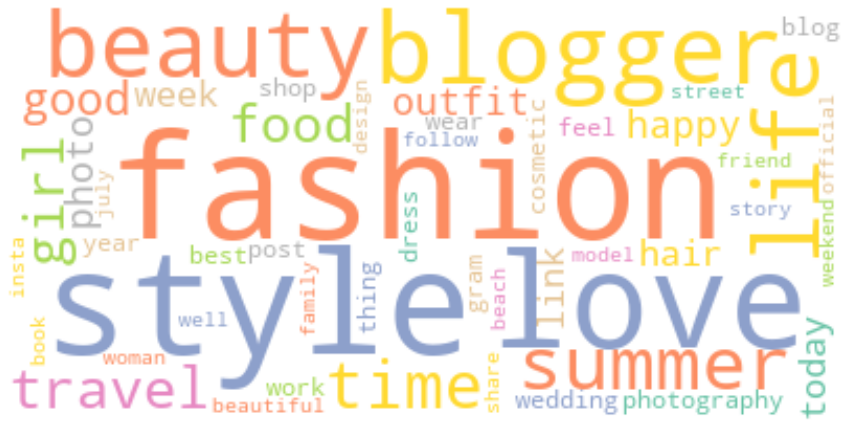

In [62]:
list_words = df.content_preprocessed.tolist()
list_words = adapt_list(list_words)
list_words = ' '.join([text for text in list_words])

# create a wordcloud object
wordcloud = WordCloud(background_color='white'
                      ,colormap='Set2'
                      ,collocations=False
                      ,max_words=50
                     )
# generate a wordcloud
wordcloud.generate(list_words)
# visualize the wordcloud
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

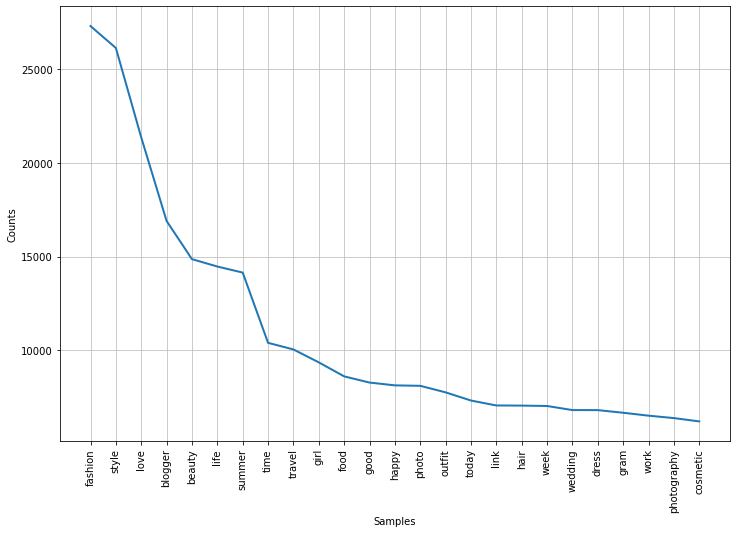

In [63]:
list_words = df.content_preprocessed.tolist()
list_words = adapt_list(list_words)
freq_dist = FreqDist(list_words)

fig, ax = plt.subplots(figsize=(12, 8))
freq_dist.plot(25, cumulative=False)
plt.show()

### Remove stopwords (instragram)  
https://towardsdatascience.com/basic-tweet-preprocessing-in-python-efd8360d529e  
https://www.ranks.nl/stopwords

In [64]:
step_name = 'stopwords_instagram'
step_num += 1
step_num

27

In [65]:
time_start = time.time()

stop_words = stopwords.words('english')

# read stopwords to add to the default list
df_stopwords_extend = pd.read_csv(file_list_stopwords_extend_instagram, names=['word'])
# dataframe to list
stopwords_extend = df_stopwords_extend['word'].values.tolist()
# extend stopwords
stop_words.extend(stopwords_extend)
# remove duplicate elements in the list
stop_words = list(dict.fromkeys(stop_words))

df['content_preprocessed'] = df['content_preprocessed'].apply(lambda x: [item for item in x if item not in stop_words])
if debug:
    df['content_stopwords_instagram'] = df['content_preprocessed']
df.to_csv(file_doc + '_' + str(step_num).zfill(2) + '_' + step_name + '.csv', index=False, header=True)

time_end = time.time()
hour, rem = divmod(time_end - time_start, 3600)
minute, second = divmod(rem, 60)
print('time elapsed - {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))

print(df['content'].head(5))
print(df['content_preprocessed'].head(5))

time elapsed - 00:00:25.36
2    you guys: do wearable easy going out glam look...
4    🧜🏼‍♀️ My new pinupstars campaign 📷⁣ Starring m...
6    Black Tape Project at Art Hearts Fashion 🇺🇸👙👙M...
7    Relax time... 🛶💦👫 #12yearstogether #годовщинас...
8    A little peak into my world.  Don’t you find i...
Name: content, dtype: object
2                          [guy, wearable, easy, glam]
4    [pinup, star, campaign, star, embo, style, hai...
6    [black, tape, project, heart, fashion, miami, ...
7                                  [relax, time, year]
8    [peak, find, strange, access, window, life, vu...
Name: content_preprocessed, dtype: object


### Wordcloud with top 50 words (after stopwords instagram)

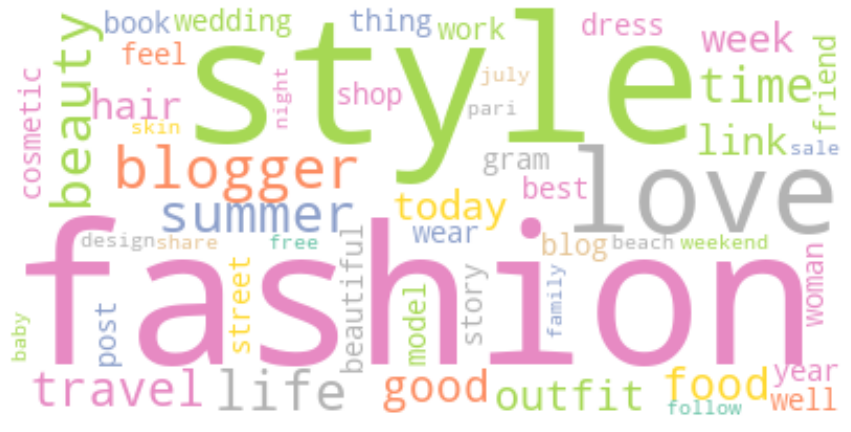

In [66]:
list_words = df.content_preprocessed.tolist()
list_words = adapt_list(list_words)
list_words = ' '.join([text for text in list_words])

# create a wordcloud object
wordcloud = WordCloud(background_color='white'
                      ,colormap='Set2'
                      ,collocations=False
                      ,max_words=50
                     )
# generate a wordcloud
wordcloud.generate(list_words)
# visualize the wordcloud
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

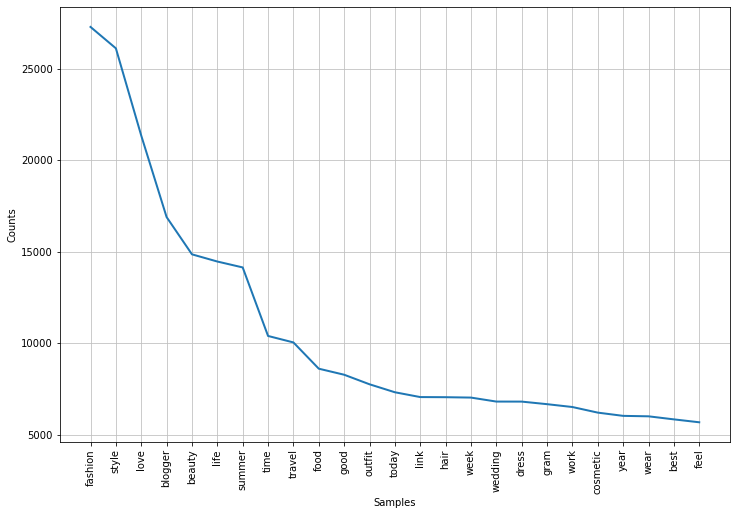

In [67]:
list_words = df.content_preprocessed.tolist()
list_words = adapt_list(list_words)
freq_dist = FreqDist(list_words)

fig, ax = plt.subplots(figsize=(12, 8))
freq_dist.plot(25, cumulative=False)
plt.show()

## Treat spelling errors  
https://medium.com/analytics-vidhya/working-with-twitter-data-b0aa5419532  
https://github.com/fsondej/autocorrect

In [68]:
# step_name = 'spelling_errors'
# step_num += 1
# step_num

In [69]:
# from autocorrect import Speller
# spell = Speller()

# def treat_spelling_errors(text):
#     text = ' '.join([spell(w) for w in text.split()])
#     return text

# time_start = time.time()
# # call function
# df['content_preprocessed'] = df['content_preprocessed'].map(lambda x: treat_spelling_errors(x))
# df.to_csv(file_doc + '_' + str(step).zfill(2) + '_' + step_name + '.csv', index=False, header=True)
# time_end = time.time()
# hour, rem = divmod(time_end - time_start, 3600)
# minute, second = divmod(rem, 60)
# print('time elapsed {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))
# df['content_preprocessed'].head(10)

## Remove rows with blank/null content_preprocessed field

In [70]:
df['content_preprocessed'].replace('[]', np.nan, inplace=True)
print('Null values before - ', df['content_preprocessed'].isnull().sum())
df = df[df['content_preprocessed'].notnull()]
print('Null values after - ', df['content_preprocessed'].isnull().sum())

Null values before -  0
Null values after -  0


## Save preprocessing results

In [71]:
step_name = 'results'
step_num += 1
step_num

28

In [72]:
if debug:
    df.to_csv(file_doc + '_' + str(step_num).zfill(2) + '_' + step_name + '_DEBUG.csv', index=False, header=True)
    # remove columns generated to analyze the data cleaning / preprocess steps
    df.drop(['content_to_lowercase'], inplace=True, axis=1)
    df.drop(['content_remove_extra_whitespaces_1'], inplace=True, axis=1)
    df.drop(['content_remove_websites'], inplace=True, axis=1)
    df.drop(['content_remove_emails'], inplace=True, axis=1)
    df.drop(['content_remove_meaningless_hashtags'], inplace=True, axis=1)
    df.drop(['content_remove_hashtag_symbol'], inplace=True, axis=1)
    df.drop(['content_remove_mentions'], inplace=True, axis=1)
    df.drop(['content_remove_colons'], inplace=True, axis=1)
    df.drop(['content_replace_emojis'], inplace=True, axis=1)
    df.drop(['content_remove_emojis'], inplace=True, axis=1)
    df.drop(['content_remove_numbers'], inplace=True, axis=1)
    df.drop(['content_remove_accents'], inplace=True, axis=1)
    df.drop(['content_remove_special_characters'], inplace=True, axis=1)
    df.drop(['content_remove_extra_whitespaces_2'], inplace=True, axis=1)
    df.drop(['content_expand_contractions'], inplace=True, axis=1)
    df.drop(['content_remove_punctuation'], inplace=True, axis=1)
    df.drop(['content_remove_3_characters_1'], inplace=True, axis=1)
    df.drop(['content_remove_underscore'], inplace=True, axis=1)
    df.drop(['content_remove_extra_whitespaces_3'], inplace=True, axis=1)
    df.drop(['content_detect_language'], inplace=True, axis=1)
    df.drop(['content_wordsegmentation'], inplace=True, axis=1)
    df.drop(['content_remove_3_characters_2'], inplace=True, axis=1)
    df.drop(['content_tokenization'], inplace=True, axis=1)
    df.drop(['content_lemmatization'], inplace=True, axis=1)
    df.drop(['content_stopwords'], inplace=True, axis=1)
    df.drop(['content_stopwords_instagram'], inplace=True, axis=1)

# final file --> will be the input to build the model
df.to_csv(file_doc + '_' + str(step_num).zfill(2) + '_' + step_name + '.csv', index=False, header=True)

print(df['content'].head(10))
print(df['content_preprocessed'].head(10))

2     you guys: do wearable easy going out glam look...
4     🧜🏼‍♀️ My new pinupstars campaign 📷⁣ Starring m...
6     Black Tape Project at Art Hearts Fashion 🇺🇸👙👙M...
7     Relax time... 🛶💦👫 #12yearstogether #годовщинас...
8     A little peak into my world.  Don’t you find i...
9                 出入冷氣地方梗係要帶件 tnf_urbanexploration_hk 🖤
10    Souvenir | La claque des #Damnés c’était il y ...
12    What a beautiful surprise to discover this bea...
13    Morning walks with my littlest ones. 💕 I’m rea...
16    Rare non-kimono snap 😆 The constant rain reall...
Name: content, dtype: object
2                           [guy, wearable, easy, glam]
4     [pinup, star, campaign, star, embo, style, hai...
6     [black, tape, project, heart, fashion, miami, ...
7                                   [relax, time, year]
8     [peak, find, strange, access, window, life, vu...
9                                  [urban, exploration]
10    [souvenir, damn, tait, choc, total, sortie, av...
12    [beautiful, s

# Remove metadata

In [73]:
if test:
    path_meta = r'D:\master\data science\semestre 4\M2.979 - tfm\data\bins_test\meta'
else:
    path_meta = r'D:\master\data science\semestre 4\M2.979 - tfm\data\bins\meta'

file_meta = os.path.join(path_meta, yyyy_MMM, yyyy_MMM)
print('file to clean & preprocess - ', file_meta  + '.csv')

file to clean & preprocess -  D:\master\data science\semestre 4\M2.979 - tfm\data\bins\meta\2019_Jul\2019_Jul.csv


In [74]:
# split meta dataset (first half)
df_meta = pd.read_csv(file_meta + '.csv', names=['id_meta', 'file', 'author_followers', 'author_full_name', 'author_id', 'author_image', 'author_name', 'author_url', 'date', 'date_from_provider', 'id', 'id_from_provider', 'image_url', 'link', 'location_latitude', 'location_longitude', 'place_country_code', 'place_name', 'place_street_address', 'provider', 'social_likes', 'social_replies'])
df_meta_merged = pd.merge(left=df, right=df_meta, left_on='id_doc', right_on='id_meta')
del df_meta_merged['id_doc']
del df_meta_merged['content']
del df_meta_merged['content_preprocessed']
df_meta_merged.to_csv(file_meta + '.csv', index=False, header=False)